<a href="https://colab.research.google.com/github/rubyvanrooyen/observation_planning/blob/main/callisto/MeerKAT_spectral_line_sensitivity_calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral line sensitivity

In [80]:
%pylab inline
import numpy as np
from astropy import constants

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


First, Tsys/eta as a function of frequency:

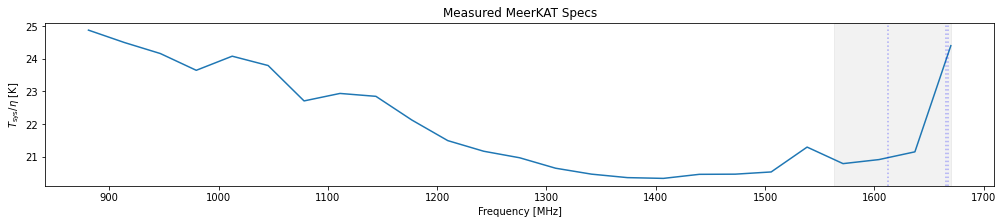

In [81]:
# Fitted values from recent work.
specs = np.array([[ 881.           ,24.87730995],
     [ 913.875        ,24.49771763],
     [ 946.75         ,24.16024859],
     [ 979.625        ,23.64646727],
     [1012.5          ,24.07896985],
     [1045.375        ,23.79283849],
     [1078.25         ,22.70843003],
     [1111.125        ,22.93770384],
     [1144.           ,22.84885476],
     [1176.875        ,22.12287765],
     [1209.75         ,21.49206455],
     [1242.625        ,21.16654511],
     [1275.5          ,20.96656328],
     [1308.375        ,20.6466135 ],
     [1341.25         ,20.46467585],
     [1374.125        ,20.35819618],
     [1407.           ,20.33486544],
     [1439.875        ,20.45917325],
     [1472.75         ,20.46422681],
     [1505.625        ,20.53214192],
     [1538.5          ,21.29373981],
     [1571.375        ,20.78716734],
     [1604.25         ,20.91109069],
     [1637.125        ,21.14846713],
     [1670.           ,24.40091906]])

fig, ax = plt.subplots(nrows=1, ncols=1,
                       figsize=(17, 3),
                       facecolor='white')
ax.plot(specs[:,0],specs[:,1])
ax.axvspan(1563.0, 1670., alpha=0.05, color='k')
ax.axvline(x=1612.2, color='b', linestyle=':', alpha=0.3)
ax.axvline(x=1665.4, color='b', linestyle=':', alpha=0.3)
ax.axvline(x=1667.4, color='b', linestyle=':', alpha=0.3)
ax.set_title('Measured MeerKAT Specs')
ax.set_ylabel('$T_\mathrm{sys}/\eta$ [K]')
i=ax.set_xlabel('Frequency [MHz]')
plt.show()

In [82]:
J = 1e26                                   # Jy to Watts conversion factor
f = specs[:,0]*1e6                         # frequency axis above in Hz
lam = constants.c.value/f                  # corresponding wavelengths in m
f_OH = 1665.4*1e6                          # OH rest frequency in Hz
D = 13.5                                   # Meters
NPol = 2
A = np.pi * (D/2)**2
Tsys_eta = specs[:,1]

Df = 54E6/32768                           # Channel width 32k mode in Hz (Bandwidth divided by channels)
Df = Df*constants.c.value/f_OH/1000.
print('32k mode channel width : {0:f} km/s @ line frequency {1:.2f} MHz'
      .format(Df, f_OH/1e6))

32k mode channel width : 0.296651 km/s @ line frequency 1665.40 MHz


For reference, the calculations that went into this are:

\begin{align*}
\frac{\Delta\nu}{\Delta V } = \frac{\nu_\mathrm{H I}}{c} 
\end{align*}

$\nu_\mathrm{H I} = 1420405751.7667 \,\mathrm{Hz}$: H I-rest-frequency

$c = 2.99792456\cdot 10^5\, \mathrm{km}\,\mathrm{s}^{-1}$: Speed of light

$\Delta \nu$: Difference between observed and rest frequency

$\Delta V$: Difference in recession velocity (between two adjacent channels)

We obtain (for a bandwidth of 856 MHz and 4096 channels):
\begin{align*}
\Delta V = 44.108\, \mathrm{km}\,\mathrm{s}^{-1}
\end{align*}
\begin{align*}
\Delta\nu = 208984 \,\mathrm{Hz}
\end{align*}

The thermal 5-sigma rms intensity-sensitivity $\sigma_\mathrm{S}$ of a (naturally-weighted) image is found using 
\begin{align*}5\sigma_\mathrm{S} = 5 \frac{2 k_\mathrm{B} T_\mathrm{sys}}{A_\mathrm{eff} [2N(N-1)\Delta \nu_\mathrm{ RF}\tau]^{1/2}}
\end{align*}

$k_\mathrm{B}$: Boltzmann-constant

$T_\mathrm{sys}$: System temperature

$A_\mathrm{eff}$: Effective Aperture (of an antenna)

$N$: Number of antennas

$\Delta \nu_\mathrm{RF}$: Frequency interval (e.g. channel width)

$\tau$: Integration time

The equations are from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_hihelpers.php, or https://ui.adsabs.harvard.edu/abs/2013tra..book.....W/abstract, respectively. Any flux density $S$/intensity (and with that the rms in intensity) can be converted to a column-density sensitivity using:

\begin{align*}
 T_\mathrm{B} = \frac{606 \, S}{\vartheta^{2}}
\end{align*}
In this equation, the *HPBW* $\vartheta$ of the synthesized beam is measured in arcseconds, and the flux density $S$ is measured in mJy, to calculate the brightness temperature $T_\mathrm{B}$. We can then calculate the HI-column density $N_\mathrm{H I}$ by integrating over the H I linewidth (measured in $\mathrm{km}\,\mathrm{s}^{-1}$):
\begin{align*}
N_{\rm H\,I} = 1.823 \times 10^{18} \! \int \! T_{\rm B} \, \mathrm{d}V          
 \end{align*}         


In [83]:
# Parameters to adjust for the observation 
F_tap = 1.6          # The Robust/tapering factor.
theta = 60.          # The synthesized beam HPBW in arcseconds  
N_x = 3e16           # Target column Density in cm^{-2}
#hours = 50           # Integration time in hours
hours = 64           # Integration time in hours
N = 58               # Number of Antennas
#velocity_width = Df*constants.c.value/f_OH/1000. #4.0 # in km/s
velocity_width = 4.0 # in km/s
obs_freq = 1.6654e9   # Observation frequency in Hz

nu = obs_freq/1e9  # GHz
snr = 2.725 + (1.6*nu**-2.75)  # RMS confusion mJy/beam
SN = snr             # Signal to Noise for detection
print(SN)

3.1184992797447775


Use the cell below to compute the flux of a spectral feature:

$T_B = \frac{\lambda^2S_\nu}{2k_B\Omega_{bm}}$   
$\frac{T_B}{K} \approx 1.360 \times \left(\frac{\lambda}{cm} \right)^2 \times \frac{S_\nu}{mJy} \times \frac{1}{\theta^2}$

At OH frequency 1.665 GHz
$\frac{T_B}{K} \approx 440.633 \times \frac{S_\nu}{mJy} \times \frac{1}{\theta^2}$

In [84]:
boltz_k = constants.k_B.value*1e7  # k=J/K => *e7 ergs/K
light_c = constants.c.value*1e2  # c=m/s => *100 cm/
wavelength = light_c/f_OH  # cm
wavenr = f_OH/light_c  # cm-1

# assuming a circular Gaussian beam
mb_const = np.pi/(4.*np.log(2.))
mb = mb_const * theta**2

# T [K] = {L^2 * S}/{2k * beam}
degrad=180./np.pi
arcsecond_deg=3600.
rad_arcsec = degrad * arcsecond_deg
radtheta = theta/rad_arcsec
# intensity from brightness temperature [erg/s/cm^2/Hz/sr]
Jy = 1e23  # [erg/s/cm^2/Hz]
# T [K] = const * wavelength**2 * (S /theta**2)
const = (rad_arcsec**2/(2*boltz_k*mb_const*1000.*Jy))
flux_factor = const*wavelength**2

# (S /theta**2) [mJy/beam] = T / 440.633
Tsky = 40  # K (minimum for detection @ 1.665 GHz over 50 hours)
Tsky = 35  # K (minimum for detection @ 1.665 GHz over 64 hours)
rmsmin = Tsky/flux_factor  # mJy/beam
print(rmsmin)

0.07943121239748765


In [85]:
# point source sensitivity
bw = f_OH/constants.c.value*velocity_width*1000.
idx_ = np.argmin(np.abs(f - obs_freq))
# fit with a second degree polynomial
x = f[idx_-1:idx_+2]
y = Tsys_eta[idx_-1:idx_+2]
if len(x) < 3: p_o = 1
else: p_o = 2
c2p = polyfit(x, y, p_o) 
p2 = poly1d(c2p)
Tsys_per_eta = p2(obs_freq)

taumin = np.power((2 * constants.k_B.value * Tsys_per_eta * J)/(A * (rmsmin/1000.) * np.sqrt(NPol)),2) \
       / (N * (N-1) * bw)

In [86]:
print('Intensity corresponding to an molecular column density:\n')

string1 = 'OH'\
          ' with a column density of N_x = {0:2.4g},\n'\
          '   observed at {1} arcseconds resolution (HPBW),\n'\
          '   with a velocity width of {2:2.4g} km/s,\n'\
          '   is observed with an intensity of {3:2.4g} mJy/beam.\n'
print(string1.format(N_x, theta, velocity_width, rmsmin))

string2 = 'To detect this\n'\
          '   at a {1:.0f}-sigma level (taper factor of {2:2.2g}),\n'\
          '   we require a data cube with a natural rms of {3:2.4g} mJy/beam\n'\
          '   (after regridding to {4:2.4g} km/s-wide channels).\n'
print(string2.format(N_x, SN, F_tap, rmsmin, velocity_width))

print ("T_sys/eta at %3.0f MHz is %2.1fK"%(obs_freq/1e6, Tsys_per_eta) )
print('   With this, to reach the required rms level, the required integration time is\n'\
      '   {0:.0f}s or {1:.2f}h.'.format(taumin, taumin/3600.))

Intensity corresponding to an molecular column density:

OH with a column density of N_x = 3e+16,
   observed at 60.0 arcseconds resolution (HPBW),
   with a velocity width of  4 km/s,
   is observed with an intensity of 0.07943 mJy/beam.

To detect this
   at a 3-sigma level (taper factor of 1.6),
   we require a data cube with a natural rms of 0.07943 mJy/beam
   (after regridding to  4 km/s-wide channels).

T_sys/eta at 1665 MHz is 23.9K
   With this, to reach the required rms level, the required integration time is
   230196s or 63.94h.


Use the cell below to compute the image rms (single-channel), and resulting detection level:

In [87]:
sigma = SN
tau = 3600 * hours
print("Thermal rms in intensity using the radiometer equation:")
noise = 2 * constants.k_B.value * Tsys_per_eta / (A * np.sqrt(N * (N-1) * bw * tau)) * J / np.sqrt(NPol) 
print("  The Natural rms after {0:.1f}h on-source, over a velocity width of {2:2.4g} km/s, is {1:2.4g} mJy/beam."
      .format(hours, noise*1e3, velocity_width)) 
print("  With a tapering penalty of {:.1f}, this becomes {:2.4g} mJy/beam."
      .format(F_tap, F_tap*noise*1e3)) 
print("  The {:.0f}-sigma detection level is then {:2.4g} mJy/beam.\n"
      .format(sigma, sigma*F_tap*noise*1e3))
print("The sensitivity is {0:.2f} times the {1:.1f}-sigma threshold sensitivity for the detection of"
      .format(1000.*noise/rmsmin, SN))
print("  HI at a column density of N_HI = {0:2.4g} atoms/sqcm at a resolution of {1} arcseconds (HPBW)."
      .format(N_x,theta))
print("  The integration time of {0:.2f}h is {1:.2f} times the integration time of {2:.2f}h to reach the threshold sensitivity."
      .format(hours, tau/taumin,taumin/3600.))

Thermal rms in intensity using the radiometer equation:
  The Natural rms after 64.0h on-source, over a velocity width of  4 km/s, is 0.0794 mJy/beam.
  With a tapering penalty of 1.6, this becomes 0.127 mJy/beam.
  The 3-sigma detection level is then 0.3962 mJy/beam.

The sensitivity is 1.00 times the 3.1-sigma threshold sensitivity for the detection of
  HI at a column density of N_HI = 3e+16 atoms/sqcm at a resolution of 60.0 arcseconds (HPBW).
  The integration time of 64.00h is 1.00 times the integration time of 63.94h to reach the threshold sensitivity.
